In [6]:

"""
CaseEligibility Analyzer (CEA): Two-Stage Legal Case Assessment Model
===============================

Purpose:
--------
A machine learning-based intake assessment tool designed to assist law firms in 
evaluating potential cases. The model employs a two-stage prediction approach:
1. Stage 1: Predicts case eligibility (likelihood of valid claim)
2. Stage 2: Estimates potential claim value for eligible cases

Version: 1.0
Last Updated: December 1, 2024
"""

'\nCaseEligibility Analyzer (CEA): Two-Stage Legal Case Assessment Model\n===============================\n\nPurpose:\n--------\nA machine learning-based intake assessment tool designed to assist law firms in \nevaluating potential cases. The model employs a two-stage prediction approach:\n1. Stage 1: Predicts case eligibility (likelihood of valid claim)\n2. Stage 2: Estimates potential claim value for eligible cases\n\nVersion: 1.0\nLast Updated: December 1, 2024\n'

In [7]:
# # Kaggle API Authentication Setup
import os
os.envir on['KAGGLE_USERNAME'] = "demiminjarez"
os.environ['KAGGLE_KEY'] = "71118f339b2ffe1143d9fec6ed72ebf7"

In [8]:
# # Install python-dotenv
# !pip install python-dotenv
# # Kaggle API Authentication Setup
# from dotenv import load_dotenv
# import os

# # Load credentials from .env file
# load_dotenv()

# # Securely access credentials
# try:
#     kaggle_username = os.getenv('KAGGLE_USERNAME')
#     kaggle_key = os.getenv('KAGGLE_KEY')
    
#     if not all([kaggle_username, kaggle_key]):
#         raise ValueError("Missing required Kaggle credentials in environment variables")
        
#     os.environ['KAGGLE_USERNAME'] = kaggle_username
#     os.environ['KAGGLE_KEY'] = kaggle_key
    
# except Exception as e:
#     print(f"Error loading Kaggle credentials: {e}")

In [9]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [10]:
# FastAI Libraries
from fastai.tabular.all import *
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from fastai.metrics import F1Score, accuracy

In [11]:
"""
Data Collection
==============
- Source: Kaggle Insurance Claims Dataset
"""

'\nData Collection\n==============\n- Source: Kaggle Insurance Claims Dataset\n'

In [12]:
# Download Kaggle Dataset
!kaggle datasets download -d saisatish09/insuranceclaimsdata

# Unzip the downloaded file
!unzip -o insuranceclaimsdata.zip -d insuranceclaimsdata
def load_csv(filename):
    current_dir = os.getcwd()
    csv_path = os.path.join(current_dir, 'insuranceclaimsdata', filename)
    return pd.read_csv(csv_path)

# Load the data
df_auto = load_csv('dataCar.csv')

Dataset URL: https://www.kaggle.com/datasets/saisatish09/insuranceclaimsdata
License(s): unknown
insuranceclaimsdata.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  insuranceclaimsdata.zip
  inflating: insuranceclaimsdata/AutoBi.csv  
  inflating: insuranceclaimsdata/AutoClaims.csv  
  inflating: insuranceclaimsdata/AutoCollision.csv  
  inflating: insuranceclaimsdata/ClaimsLong.csv  
  inflating: insuranceclaimsdata/IndustryAuto.csv  
  inflating: insuranceclaimsdata/SingaporeAuto.csv  
  inflating: insuranceclaimsdata/Thirdparty.csv  
  inflating: insuranceclaimsdata/WorkersComp.csv  
  inflating: insuranceclaimsdata/dataCar.csv  
  inflating: insuranceclaimsdata/dataOhlsson.csv  


In [13]:
# Create a copy before any modifications
df_auto_processed = df_auto.copy()

In [14]:
# Check for missing values
missing_values = df_auto_processed.isnull().sum()
missing_values

Index        0
veh_value    0
exposure     0
clm          0
numclaims    0
claimcst0    0
veh_body     0
veh_age      0
gender       0
area         0
agecat       0
X_OBSTAT_    0
dtype: int64

In [15]:
df_auto_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67856 entries, 0 to 67855
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      67856 non-null  int64  
 1   veh_value  67856 non-null  float64
 2   exposure   67856 non-null  float64
 3   clm        67856 non-null  int64  
 4   numclaims  67856 non-null  int64  
 5   claimcst0  67856 non-null  float64
 6   veh_body   67856 non-null  object 
 7   veh_age    67856 non-null  int64  
 8   gender     67856 non-null  object 
 9   area       67856 non-null  object 
 10  agecat     67856 non-null  int64  
 11  X_OBSTAT_  67856 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 6.2+ MB


In [16]:
# Check unique values in 'X_OBSTAT_' column
print(df_auto_processed['X_OBSTAT_'].unique())

['01101    0    0    0']


In [17]:
# Remove 'X_OBSTAT_' column from dataset
# Rationale:
# Column contains administrative status codes not relevant to claim prediction
if 'X_OBSTAT_' in df_auto_processed.columns:
  df_auto_processed = df_auto_processed.drop('X_OBSTAT_', axis=1)
  print("Column 'X_OBSTAT_' dropped successfully.")
else:
  print("Column 'X_OBSTAT_' not found in the DataFrame.")

Column 'X_OBSTAT_' dropped successfully.


In [18]:
# Analyze the claim costs distribution
print("Claim cost statistics:")
print(df_auto_processed['claimcst0'].describe())

Claim cost statistics:
count    67856.000000
mean       137.270167
std       1056.297768
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      55922.129880
Name: claimcst0, dtype: float64


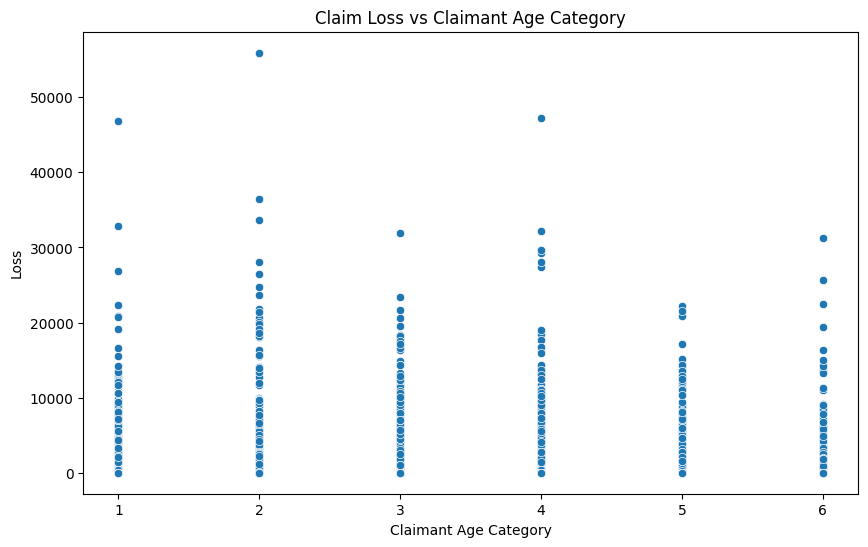

In [19]:
# Scatter plot of claim loss vs claimant age category
plt.figure(figsize=(10, 6))
sns.scatterplot(x='agecat', y='claimcst0', data=df_auto_processed)
plt.title('Claim Loss vs Claimant Age Category')
plt.xlabel('Claimant Age Category')
plt.ylabel('Loss')
plt.show()

/var/folders/g5/m1slb69s58l1xjf8nbrnywf00000gn/T/ipykernel_80367/236851761.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1000x600 with 0 Axes>

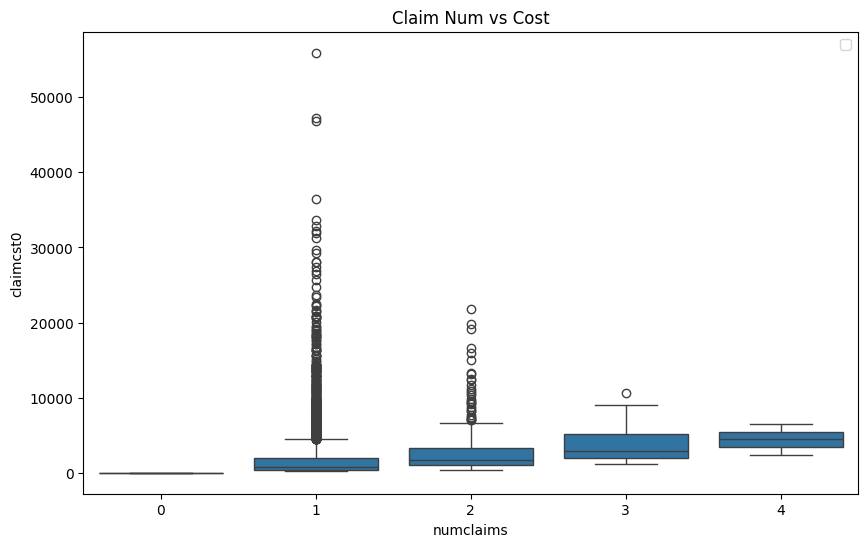

In [20]:
# Analyze the relationship between insurance claim amount and loss
plt.figure(figsize=(10, 6))

# Box plot of LOSS by Insured status
plt.figure(figsize=(10, 6))
sns.boxplot(x='numclaims', y='claimcst0', data=df_auto_processed)
plt.title('Claim Num vs Cost')

plt.xlabel('numclaims')
plt.ylabel('claimcst0')

# Add a legend
plt.legend()
plt.show()

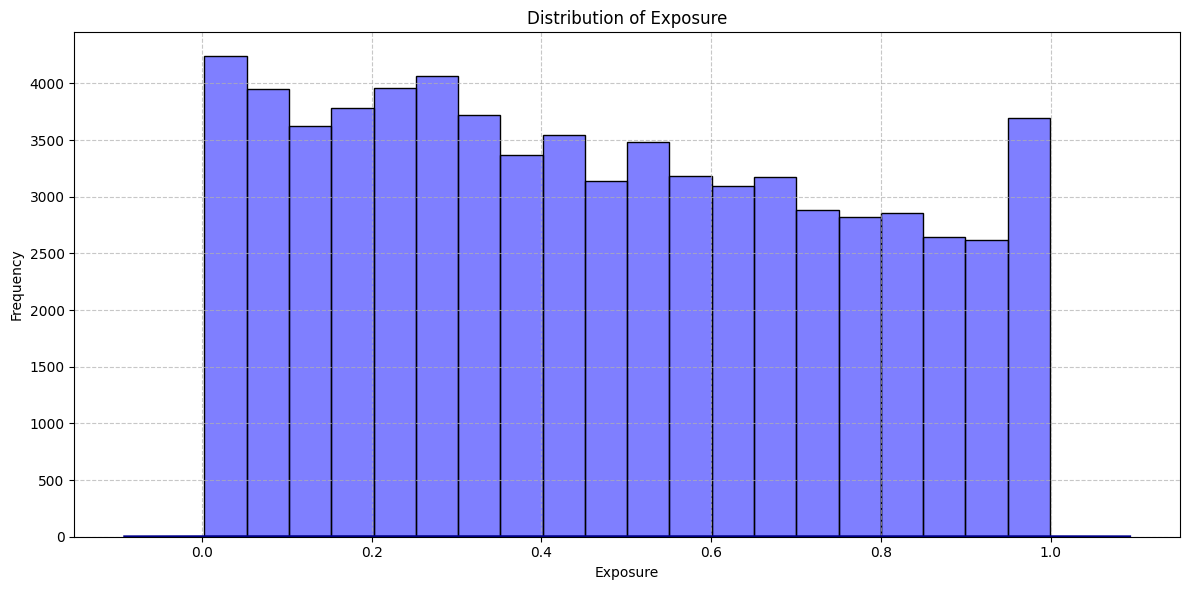

In [21]:
# Distribution of Exposure 
plt.figure(figsize=(12, 6))
sns.histplot(data=df_auto_processed, x='exposure', bins=20, color='blue', alpha=0.5)
sns.kdeplot(data=df_auto_processed, x='exposure', color='darkblue', linewidth=2)

# Set title and labels
plt.title('Distribution of Exposure', fontsize=12)
plt.xlabel('Exposure')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)

# Add some style
#plt.style.use('seaborn')
plt.tight_layout()
plt.show()

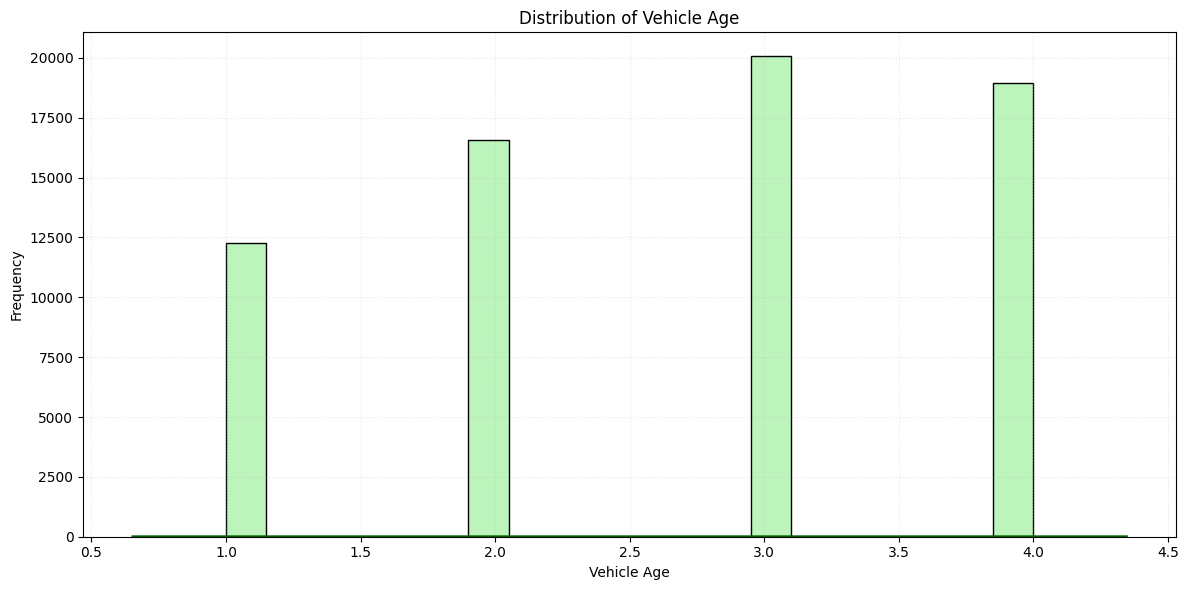


Vehicle Age Statistics:
count    67856.000000
mean         2.673529
std          1.067542
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: veh_age, dtype: float64


In [22]:
# Distribution of Vehicle Age
plt.figure(figsize=(12, 6))

# Create histogram and KDE plot
sns.histplot(data=df_auto_processed, x='veh_age', bins=20, color='#90EE90', alpha=0.6)  # Light green color
sns.kdeplot(data=df_auto_processed, x='veh_age', color='darkgreen', linewidth=2)

# Customize the plot
plt.title('Distribution of Vehicle Age', fontsize=12)
plt.xlabel('Vehicle Age')
plt.ylabel('Frequency')
plt.grid(True, linestyle=':', alpha=0.3)

# Style adjustments
#plt.style.use('seaborn')
plt.tight_layout()
plt.show()

# Optional: Print basic statistics
print("\nVehicle Age Statistics:")
print(df_auto_processed['veh_age'].describe())

In [23]:
# Optional: Print basic statistics
print("\nVehicle Value Statistics:")
print(df_auto_processed['veh_value'].describe())


Vehicle Value Statistics:
count    67856.000000
mean         1.777021
std          1.205232
min          0.000000
25%          1.010000
50%          1.500000
75%          2.150000
max         34.560000
Name: veh_value, dtype: float64


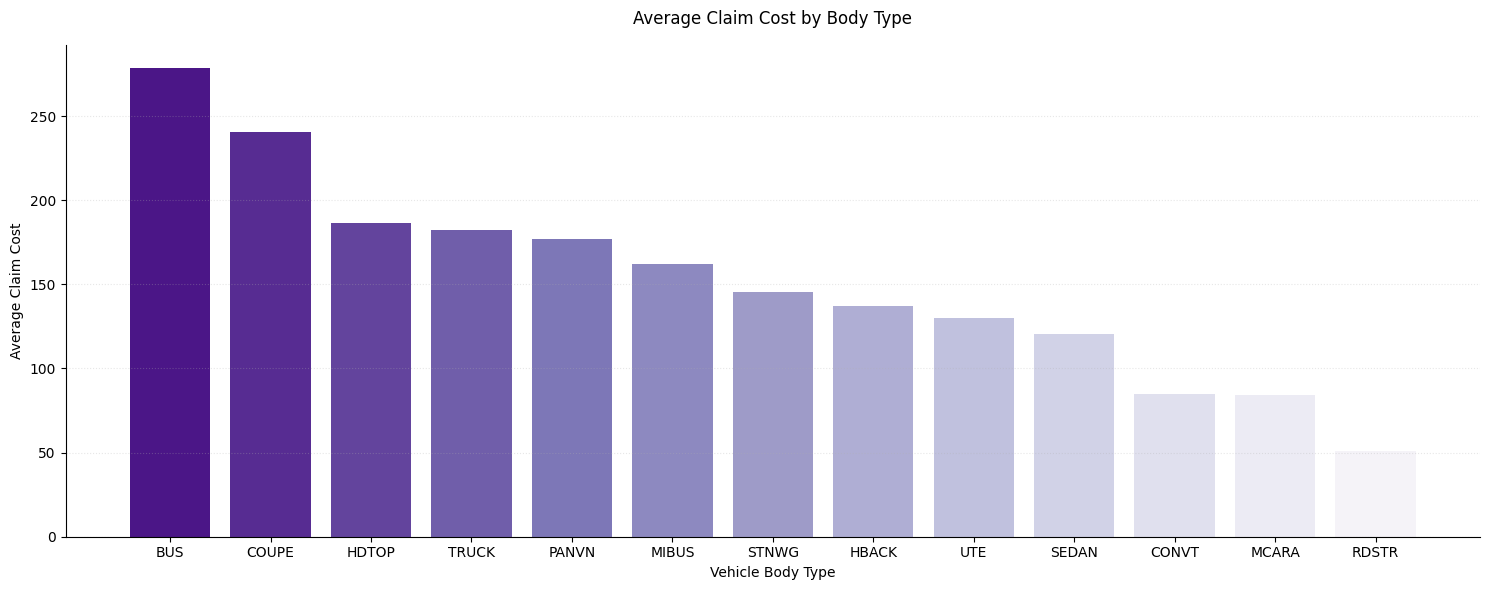

In [24]:
# Calculate average claim cost by body type
avg_claim_by_body = df_auto_processed.groupby('veh_body')['claimcst0'].mean().sort_values(ascending=False)

# Create monochromatic color palette (purple shades) and reverse it
colors = sns.color_palette("Purples_r", n_colors=len(avg_claim_by_body))  # Added _r to reverse

# Create the plot
plt.figure(figsize=(15, 6))
bars = plt.bar(range(len(avg_claim_by_body)), avg_claim_by_body.values, color=colors)

# Customize the plot
plt.title('Average Claim Cost by Body Type', fontsize=12, pad=15)
plt.xlabel('Vehicle Body Type')
plt.ylabel('Average Claim Cost')

# Set x-axis labels
plt.xticks(range(len(avg_claim_by_body)), 
          avg_claim_by_body.index,
          rotation=0)

# Add grid
plt.grid(axis='y', linestyle=':', alpha=0.3)

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

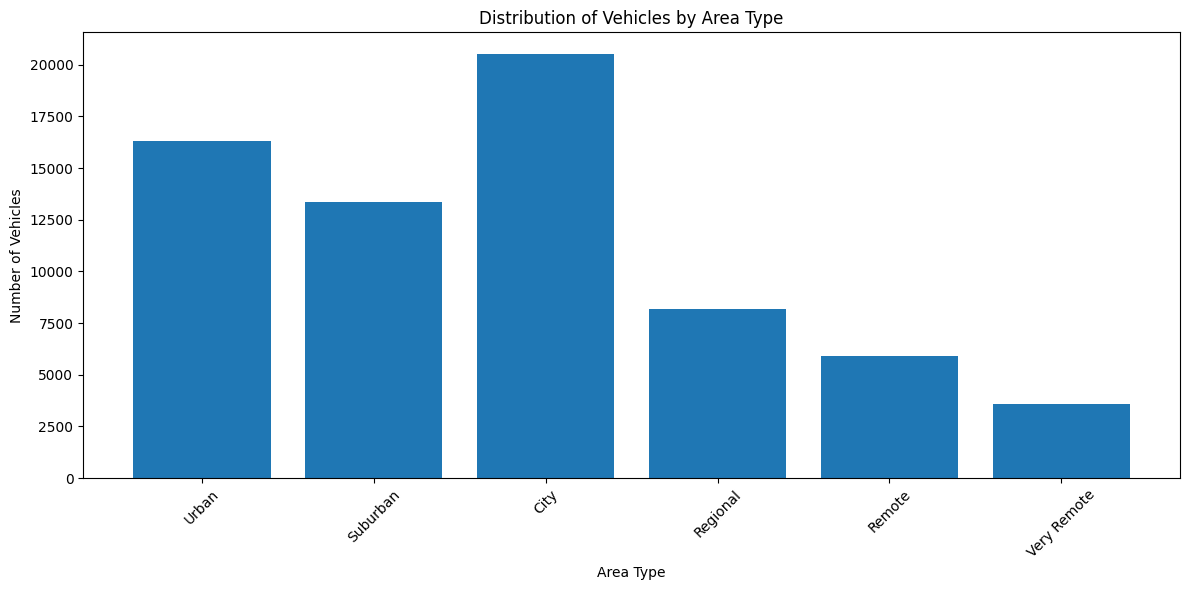

In [25]:
# Create mapping for area types
area_mapping = {
    0: 'Urban',
    1: 'Suburban',
    2: 'City',
    3: 'Regional',
    4: 'Remote',
    5: 'Very Remote'
}

# Create the plot
plt.figure(figsize=(12, 6))
area_counts = df_auto_processed['area'].value_counts().sort_index()

# Create bar plot
plt.bar(range(len(area_counts)), area_counts.values)

# Customize plot
plt.title('Distribution of Vehicles by Area Type')
plt.xlabel('Area Type')
plt.ylabel('Number of Vehicles')
plt.xticks(range(len(area_counts)), [area_mapping[x] for x in range(6)], rotation=45)
plt.tight_layout()
plt.show()

# Print percentages
# total = area_counts.sum()
# print("\nPercentage distribution:")
# for area_code, count in area_counts.items():
#     area_name = area_mapping[area_code]
#     percentage = (count/total * 100).round(2)
#     print(f"{area_name}: {percentage}% ({count} vehicles)")

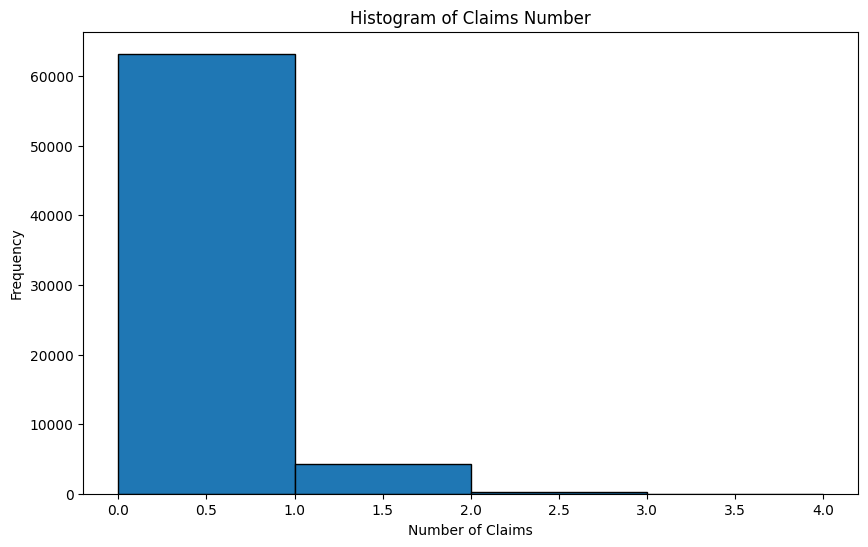

In [26]:
# Histogram of claims number
plt.figure(figsize=(10, 6))
plt.hist(df_auto_processed['numclaims'], bins=4, edgecolor='black')
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.title('Histogram of Claims Number')
plt.show()

/var/folders/g5/m1slb69s58l1xjf8nbrnywf00000gn/T/ipykernel_80367/1285927420.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clm_counts.index, y=clm_counts.values, palette='viridis')


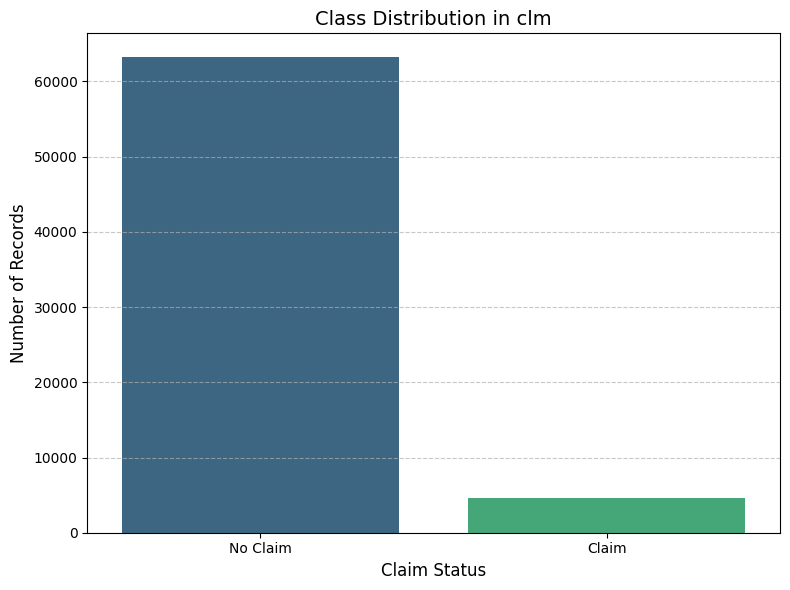

In [27]:
# Count the occurrences of each class in 'clm'
clm_counts = df_auto_processed['clm'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=clm_counts.index, y=clm_counts.values, palette='viridis')

# Customize the plot
plt.title('Class Distribution in clm', fontsize=14)
plt.xlabel('Claim Status', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks([0, 1], ['No Claim', 'Claim'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Vehicle Age Statistics:
count    67856.000000
mean         2.673529
std          1.067542
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: veh_age, dtype: float64

Oldest vehicle age: 4

Number of vehicles by age:
veh_age
1    12257
2    16587
3    20064
4    18948
Name: count, dtype: int64


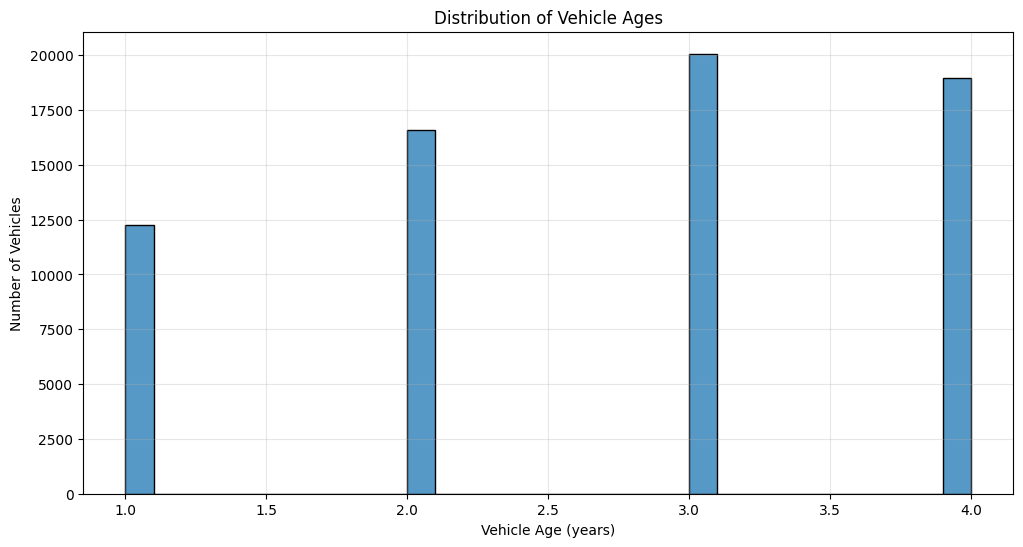


Top 10 oldest vehicle ages and their counts:
veh_age
4    18948
3    20064
2    16587
1    12257
Name: count, dtype: int64


In [28]:
# Basic statistics of vehicle age
print("Vehicle Age Statistics:")
print(df_auto_processed['veh_age'].describe())

# Get the maximum age
max_age = df_auto_processed['veh_age'].max()
print(f"\nOldest vehicle age: {max_age}")

# Count of vehicles by age
age_counts = df_auto_processed['veh_age'].value_counts().sort_index()
print("\nNumber of vehicles by age:")
print(age_counts)

# Create a histogram to visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_auto_processed, x='veh_age', bins=30)
plt.title('Distribution of Vehicle Ages')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Number of Vehicles')
plt.grid(True, alpha=0.3)
plt.show()

# 
print("\nTop 10 oldest vehicle ages and their counts:")
print(age_counts.tail(10).sort_index(ascending=False))

In [29]:
# need to check the correlation between the features and the target variable
# correlation_matrix = df_auto_processed.corr()

In [30]:
# Data Preprocessing
"""
Data Preprocessing Steps
=======================
1. Data cleaning
   - Add "has_claim" column to the dataframe
   - Removing columns related to the target variable (clm, claimcs0, Index, numclaims)
   - No missing values
"""

'\nData Preprocessing Steps\n=======================\n1. Data cleaning\n   - Add "has_claim" column to the dataframe\n   - Removing columns related to the target variable (clm, claimcs0, Index, numclaims)\n   - No missing values\n'

In [31]:
 # Check unique values and their counts
print(df_auto_processed['clm'].value_counts())
   
   # Display basic statistics
print(df_auto_processed['clm'].describe())

clm
0    63232
1     4624
Name: count, dtype: int64
count    67856.000000
mean         0.068144
std          0.251995
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: clm, dtype: float64


In [32]:
# Create binary target for claim eligibility (Stage 1)
df_auto_processed['has_claim'] = (df_auto_processed['clm'] > 0).astype(int)

In [33]:
# Define features and target
y_clm = df_auto_processed['has_claim']
X = df_auto_processed.drop(['clm', 'claimcst0', 'Index', 'numclaims'], axis=1)



In [34]:
# Add this after creating has_claim
print("Class distribution before resampling:")
print(df_auto_processed['has_claim'].value_counts(normalize=True))


Class distribution before resampling:
has_claim
0    0.931856
1    0.068144
Name: proportion, dtype: float64


In [35]:

"""
RandomUnderSampler Start
===============================
Applying RandomUnderSampler to the majority class to balance the dataset
"""

'\nRandomUnderSampler Start\n===============================\nApplying RandomUnderSampler to the majority class to balance the dataset\n'

In [36]:
# pip install imbalanced-learn
!pip install imbalanced-learn
#from imblearn.over_sampling import SMOTE
from fastai.metrics import F1Score
from imblearn.under_sampling import RandomUnderSampler

In [37]:
# This function is used to resample the data to balance the dataset
def perform_undersampling(x, y, random_state=42):
    # Initialize the undersampler
    rus = RandomUnderSampler(random_state=random_state)

    # Apply undersampling
    X_resampled, y_resampled = rus.fit_resample(x, y)

    # Verify data
    print("\nResampled shape:", X_resampled.shape)
    #print("\nFeature types:")
    #print(X_resampled.dtypes)

    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled['has_claim'] = y_resampled

    return df_resampled

In [38]:

"""
RandomUnderSampler END
===============================
Applying RandomUnderSampler to the majority class to balance the dataset
"""

'\nRandomUnderSampler END\n===============================\nApplying RandomUnderSampler to the majority class to balance the dataset\n'

In [39]:

"""
Handle and remove outliers
===============================

"""

'\nHandle and remove outliers\n===============================\n\n'

In [40]:
# Install scipy library
!pip install scipy

In [41]:
# Import scipy library
from scipy import stats

In [42]:
# Define categorical/continuous variables
cat_cols = ['veh_body', 'gender', 'area', 'agecat', 'veh_age']
# Include 'index' in continuous columns
cont_cols = ['veh_value', 'exposure'] 

In [43]:
# Remove outliers from all columns
def remove_outliers(df, columns, n_std=3):
    df_clean = df.copy()
    for col in columns:
        mean = df_clean[col].mean()
        std = df_clean[col].std()
        df_clean = df_clean[abs(df_clean[col] - mean) <= (n_std * std)]
    return df_clean


# Remove outliers from continuous columns 
df_auto_processed = remove_outliers(df_auto_processed, cont_cols, n_std=3)



In [44]:
"""
Handle and remove outliers END
===============================
"""

'\nHandle and remove outliers END\n===============================\n'

In [45]:
"""
Stage 1: Claim Eligibility
===============================
- Binary classification: 0 (No Claim) or 1 (Claim)
- Drop numclaims for Stage 1
- Define the dependent variable and categorical/continuous variables
- Split the data into training and testing sets
- Create dataloaders
- Train the model
- Evaluate the model
"""

'\nStage 1: Claim Eligibility\n===============================\n- Binary classification: 0 (No Claim) or 1 (Claim)\n- Drop numclaims for Stage 1\n- Define the dependent variable and categorical/continuous variables\n- Split the data into training and testing sets\n- Create dataloaders\n- Train the model\n- Evaluate the model\n'

In [46]:
# This function is used to create a dataloader for Stage 1
def create_stage1_dataloader(df_stage1, valid_pct=0.2, bs=64):
    procs = [Categorify, FillMissing]

    splits = RandomSplitter(valid_pct=valid_pct)(range_of(df_stage1))
        
    to_eligibility = TabularPandas(
        df_stage1, 
        procs=procs, 
        cat_names=cat_cols, 
        cont_names=cont_cols, 
        y_names='has_claim', 
        y_block=CategoryBlock,  # Explicitly specify categorical target
        splits=splits
    )
    dls_eligibility = to_eligibility.dataloaders(bs=64, shuffle_train=True, val_bs=64, drop_last=True)


    return dls_eligibility

In [47]:
# Define the custom splitter at the global scope
class ResamplingTrainSplitter:
    def __init__(self, df_stage1, valid_pct=0.2):
        self.df_stage1 = df_stage1
        self.valid_pct = valid_pct

    def __call__(self, items):  
        # Get the original dataframe indices
        df_indices = np.arange(len(self.df_stage1))
        
        # Resample training data
        X = self.df_stage1.drop('has_claim', axis=1)
        y = self.df_stage1['has_claim']
        rus = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X, y)
        
        # Calculate number of validation samples
        n_valid = int(len(self.df_stage1) * self.valid_pct)
        
        # Create train/valid indices
        valid_idx = np.random.choice(df_indices, size=n_valid, replace=False)
        train_idx = np.arange(len(X_resampled))  # Use indices of resampled data
        
        return train_idx, valid_idx

In [48]:
# This function is used to resample the data to balance the dataset
def resample_data(df, dep_var, random_state=42):
    # Separate features and target
    X = df.drop(dep_var, axis=1).reset_index(drop=True)
    y = df[dep_var].reset_index(drop=True)
    
    sampling_strategy = 0.5  # This means majority:minority = 2:1

    # Apply Random UnderSampling
    rus = RandomUnderSampler(random_state=random_state, sampling_strategy=sampling_strategy)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    # Create resampled DataFrame
    df_resampled = pd.concat(
        [
            pd.DataFrame(X_resampled, columns=X.columns),
            pd.Series(y_resampled, name=dep_var)
        ],
        axis=1
    )
    return df_resampled

In [49]:
# This function is used to train the model with the best parameters
def train_model_with_params(n_layers, layer_sizes, lr):
    # Prepare the full dataset
    df_stage1 = X.copy()

        # Convert categorical columns to category dtype
    for col in cat_cols:
        df_stage1[col] = df_stage1[col].astype('category')

    # Define preprocessing steps
    procs = [Categorify, FillMissing]
    
    # Create splits for training and validation set
    # Use the original data for validation
    splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df_stage1))
    
    # Create TabularPandas for initial data
    to = TabularPandas(
        df_stage1,
        procs=procs,
        cat_names=cat_cols,
        cont_names=cont_cols,
        y_names='has_claim',
        y_block=CategoryBlock,
        splits=splits
    )
    
    # Create DataLoaders
    dls = to.dataloaders(bs=64)
    
    # Initialize the learner with the initial DataLoaders
    learn = tabular_learner(
        dls,
        layers=layer_sizes,
        metrics=[accuracy, F1Score()],
        loss_func=CrossEntropyLossFlat(),
        wd=0.01  # Weight decay
    )
    
    # Number of epochs you want to train
    n_epochs = 5  # You can adjust this as needed
    
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}/{n_epochs}")
        
        # Resample the data
        df_resampled = resample_data(df_stage1, 'has_claim')
        
        # Create splits for resampled data
        # All data in train; empty validation since we're keeping validation from original data
        splits_resampled = (range_of(df_resampled), [])  # All data in training set
        
        # Re-create the TabularPandas object for training data
        # Ensure categorical columns are of type 'category'
        for col in cat_cols:
            df_resampled[col] = df_resampled[col].astype('category')
        
        to_resampled = TabularPandas(
            df_resampled,
            procs=procs,
            cat_names=cat_cols,
            cont_names=cont_cols,
            y_names='has_claim',
            y_block=CategoryBlock,
            splits=splits_resampled
        )

        # Create new training DataLoader
        train_dl = to_resampled.dataloaders(bs=64).train  # Get the training DataLoader
        
        # Update the learner's training DataLoader
        learn.dls.train = train_dl
        
        # Train for one epoch
        learn.fit(1, lr)
        
    # After training, retrieve metrics
    # Get the names of the metrics
    metrics_names = [m.name for m in learn.metrics]

    # Get the last recorded values (training loss, validation loss, metrics)
    last_epoch_values = learn.recorder.values[-1]  # List of [train_loss, valid_loss, metric1, metric2, ...]

    # The metrics start after the losses
    metrics_values = last_epoch_values[2:]  # Skip train_loss and valid_loss

    # Create a dictionary mapping metric names to their values
    metrics_dict = dict(zip(metrics_names, metrics_values))

    # Access accuracy and F1 score
    acc = metrics_dict.get('accuracy')
    f1 = metrics_dict.get('f1_score')

    return learn, acc, f1

In [50]:
# Define Stage 1 parameter grid
layer_configs = [
    #[100,50],
    [200,100],
    #[300,150],
    #[200,100,50],
    #[400,200,100],  # Added deeper networks
    #[150,100,50,25]  # Added deeper network with smaller layers
]
learning_rates = [1e-3]#, 1e-2, 5e-1] 


# Perform Stage 1 grid search
results = []
for layers in layer_configs:
    for lr in learning_rates:
        print(f"\nTrying layers={layers}, lr={lr}")
        learn, acc, f1 = train_model_with_params(len(layers), layers, lr)
        results.append({
            'layers': layers,
            'lr': lr,
            'accuracy': acc,
            'f1_score': f1,
            'model': learn  # Store the model
        })

# Find best parameters
best_result = max(results, key=lambda x: x['f1_score'])
print(f"\nBest parameters:")
print(f"Layers: {best_result['layers']}")
print(f"Learning rate: {best_result['lr']}")
print(f"Accuracy: {float(best_result['accuracy']):.4f}")
print(f"F1 Score: {float(best_result['f1_score']):.4f}")


Trying layers=[200, 100], lr=0.001

Epoch 1/5


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.606240,0.450521,0.907008,0.081514,00:05



Epoch 2/5


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.608286,0.453369,0.810552,0.176226,00:03



Epoch 3/5


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.603437,0.448363,0.856238,0.169434,00:03



Epoch 4/5


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.607526,0.444721,0.851227,0.168109,00:04



Epoch 5/5


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.599187,0.429297,0.863533,0.162749,00:04



Best parameters:
Layers: [200, 100]
Learning rate: 0.001
Accuracy: 0.8635
F1 Score: 0.1627


In [51]:
"""
Hugging Face Start
===============================
- Save and export Stage 1 Trained Model
"""

'\nHugging Face Start\n===============================\n- Save and export Stage 1 Trained Model\n'

In [52]:
# Find the best Stage 1 result
best_result = max(results, key=lambda x: x['f1_score'])
best_learn = best_result['model']

# Save the Stage 1 model
best_learn.export('stage1_claim_classifier.pkl')

Original Data Statistics:
          veh_value      exposure
count  66821.000000  66821.000000
mean       1.698113      0.469091
std        0.988466      0.290269
min        0.000000      0.002738
25%        1.000000      0.219028
50%        1.480000      0.446270
75%        2.100000      0.709103
max        5.390000      0.999316

Scaled Data Statistics:
          veh_value      exposure
count  6.682100e+04  6.682100e+04
mean   4.678751e-18  1.616296e-16
std    1.000007e+00  1.000007e+00
min   -1.717940e+00 -1.606638e+00
25%   -7.062642e-01 -8.614946e-01
50%   -2.206598e-01 -7.862191e-02
75%    4.065793e-01  8.268694e-01
max    3.734993e+00  1.826683e+00


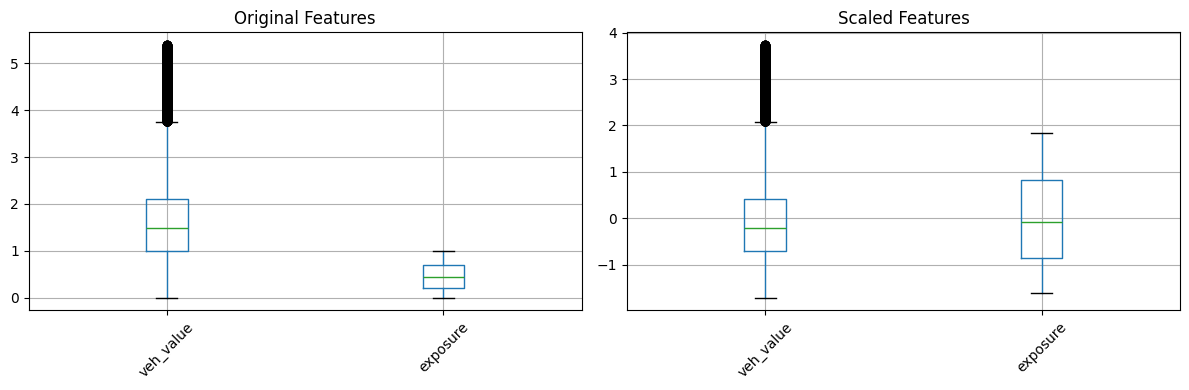

In [53]:
"""
Standardize the continuous variables
===============================
"""
from sklearn.preprocessing import StandardScaler

# 1. Display summary statistics of original data
# To understand the initial distribution of our features
print("Original Data Statistics:")
print(df_auto_processed[cont_cols].describe())

# 2. Initialize and apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_auto_processed[cont_cols])

# 3. Convert scaled data back to DataFrame for easier inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=cont_cols)

# 4. Check statistics of scaled data
print("\nScaled Data Statistics:")
print(X_scaled_df.describe())

# 5. Optional: Visual verification with boxplots
import matplotlib.pyplot as plt

# Original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df_auto_processed[cont_cols].boxplot()
plt.title('Original Features')
plt.xticks(rotation=45)

# Scaled data
plt.subplot(1, 2, 2)
X_scaled_df.boxplot()
plt.title('Scaled Features')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [54]:
"""
Stage 2: Claim Amount
===============================
- Predict the potential claim value for eligible cases
- Drop unnecessary columns
- Add numclaims to the dataset
- Drop numclaims 0
"""

'\nStage 2: Claim Amount\n===============================\n- Predict the potential claim value for eligible cases\n- Drop unnecessary columns\n- Add numclaims to the dataset\n- Drop numclaims 0\n'

In [55]:
# Create a copy of the preprocessed DataFrame
df_stage2 = df_auto_processed.copy()

# Display the first few rows
df_stage2.head()

,Index,veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,has_claim
0,1,1.06,0.303901,0,0,0.0,HBACK,3,F,C,2,0
1,2,1.03,0.648871,0,0,0.0,HBACK,2,F,A,4,0
2,3,3.26,0.569473,0,0,0.0,UTE,2,F,E,2,0
3,4,4.14,0.317591,0,0,0.0,STNWG,2,F,D,2,0
4,5,0.72,0.648871,0,0,0.0,HBACK,4,F,C,2,0


In [56]:
# Analyze the distribution of claims in Stage 2 dataset
print(df_stage2['clm'].value_counts())
   

clm
0    62260
1     4561
Name: count, dtype: int64


In [57]:
# Check unique values and their counts
print(df_stage2['numclaims'].value_counts())

numclaims
0    62260
1     4275
2      266
3       18
4        2
Name: count, dtype: int64


In [58]:
# Remove redundant 'has_claim' column from Stage 2 dataset
# Rationale:
# 1. Stage 2 only includes cases that have claims (has_claim = 1)
# 2. This column provides no additional information for claim amount prediction
# 3. Removing it prevents data leakage and reduces unnecessary features
if 'has_claim' in df_stage2.columns:
    print("Dropping 'has_claim' column")
    df_stage2 = df_stage2.drop(columns=['has_claim'])

Dropping 'has_claim' column


In [59]:
# Remove binary 'clm' column from Stage 2 dataset
# Rationale:
# 1. Stage 2 focuses on predicting claim amount, not claim existence
# 2. All records in Stage 2 have claims (clm = 1), making this column constant
# 3. Removing constant features improves model efficiency and prevents redundancy
if 'clm' in df_stage2.columns:
    print("Dropping 'clm' column")
    df_stage2 = df_stage2.drop(columns=['clm'])

Dropping 'clm' column


In [60]:
# Remove 'Index' column from Stage 2 dataset
# Rationale:
# Index is just a row identifier and carries no predictive value
if 'Index' in df_stage2.columns:
    print("Dropping 'Index' column")
    df_stage2 = df_stage2.drop(columns=['Index'])

Dropping 'Index' column


In [61]:
# Filter dataset to include only valid claim cases
# Only predict claim cost (clmcst0) if there is a claim (nu_claims > 0)
df_stage2 = df_stage2[df_stage2['numclaims'] > 0].reset_index(drop=True)

# Verify that 'numclaims' no longer contains zero
print(df_stage2['numclaims'].value_counts())

numclaims
1    4275
2     266
3      18
4       2
Name: count, dtype: int64


In [62]:
# Define the target variable
dep_var_stage2 = 'claimcst0'

In [63]:
# Define categorical and continuous variables
cat_names_stage2 = ['veh_body', 'gender', 'area', 'agecat', 'veh_age']
cont_names_stage2 = ['veh_value', 'exposure', 'numclaims']

In [64]:
# Display feature names
print("Categorical variables:", cat_names_stage2)
print("Continuous variables:", cont_names_stage2)

Categorical variables: ['veh_body', 'gender', 'area', 'agecat', 'veh_age']
Continuous variables: ['veh_value', 'exposure', 'numclaims']


In [65]:
# Check for missing values
print("Missing values in the dataset:")
print(df_stage2.isnull().sum())

Missing values in the dataset:
veh_value    0
exposure     0
numclaims    0
claimcst0    0
veh_body     0
veh_age      0
gender       0
area         0
agecat       0
dtype: int64


In [66]:
# Convert categorical columns to 'category' dtype
for col in cat_names_stage2:
    df_stage2[col] = df_stage2[col].astype('category')

In [67]:
# Verify data types
print("\nData types after conversion:")
print(df_stage2.dtypes)


Data types after conversion:
veh_value     float64
exposure      float64
numclaims       int64
claimcst0     float64
veh_body     category
veh_age      category
gender       category
area         category
agecat       category
dtype: object


In [68]:
# Import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [69]:
# Create a copy of the dataframe
df_rf = df_stage2.copy()

In [70]:
# Define the target variable
y = df_rf['claimcst0']
# Drop the target variable and the related columns
X = df_rf.drop(columns=['claimcst0'])  

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=cat_names_stage2, drop_first=True)

In [71]:
# Display the first few rows of the encoded dataset
X.head()

,veh_value,exposure,numclaims,veh_body,veh_age,gender,area,agecat
0,1.66,0.484600,1,SEDAN,3,M,B,6
1,1.51,0.993840,1,SEDAN,3,F,F,4
2,0.76,0.539357,1,HBACK,3,M,C,4
3,1.89,0.654346,2,STNWG,3,M,F,2
4,4.06,0.851472,1,STNWG,2,M,F,3


In [72]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [73]:
# Install xgboost (only needs to be done once)
!pip install xgboost

import xgboost as xgb

# Initialize the model
xgb_regressor = xgb.XGBRegressor(
      n_estimators=500,
      learning_rate=0.1,
      max_depth=6,
      random_state=42
)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor.predict(X_test)

In [74]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import VotingRegressor
# from sklearn.ensemble import GradientBoostingRegressor

# param_grid = {
#     # Parameters for XGBoost
#     'xgb__n_estimators': [500],
#     'xgb__max_depth': [4],
#     'xgb__learning_rate': [0.01],
#     'xgb__subsample': [0.8],
#     'xgb__colsample_bytree': [0.8],
    
#     # Parameters for RandomForest
#     'rf__n_estimators': [100, 500],
#     'rf__max_depth': [None, 10],
#     'rf__max_features': ['sqrt'],
#     'rf__min_samples_split': [2, 5],
    
#     # Parameters for GradientBoostingRegressor
#     'gbr__n_estimators': [100, 500],
#     'gbr__max_depth': [3, 5],
#     'gbr__learning_rate': [0.01, 0.1],
#     'gbr__subsample': [0.8, 1]
# }

# # Initialize individual models
# model1 = xgb.XGBRegressor(random_state=42)
# model2 = RandomForestRegressor(n_estimators=500, random_state=42)
# model3 = GradientBoostingRegressor(random_state=42)

# # Combine models
# ensemble_model = VotingRegressor([
#     ('xgb', model1),
#     ('rf', model2),
#     ('gbr', model3)
# ])

# # Train ensemble model
# ensemble_model.fit(X_train, y_train)

# random_search = RandomizedSearchCV(
#     estimator=ensemble_model,
#     param_distributions=param_grid,
#     n_iter=20,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     verbose=1,
#     random_state=42
#     #n_jobs=-1
# )

# random_search.fit(X_train, y_train)

# print("Best parameters found: ", random_search.best_params_)

# # Use the best estimator
# ensemble_best = random_search.best_estimator_

# # Make predictions and evaluate
# y_pred = ensemble_best.predict(X_test)

# # Evaluate the model
# mse = mean_squared_error(y_test, y_pred)
# my_rmse = mse ** 0.5
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print(f"Optimized RMSE: {my_rmse:.2f}")
# print(f"Optimized MAE: {mae:.2f}")
# print(f"Optimized R² Score: {r2:.4f}")

In [75]:
# Create dataloader for Stage 2
def create_stage2_dataloader(df_stage2, valid_pct=0.2, bs=64):
    procs = [Categorify, FillMissing, Normalize]
    splits = RandomSplitter(valid_pct=valid_pct, seed=42)(range_of(df_stage2))
    to_regression = TabularPandas(
        df_stage2,
        procs=procs,
        cat_names=cat_names_stage2,
        cont_names=cont_names_stage2,
        y_names=dep_var_stage2,
        y_block=RegressionBlock(),
        splits=splits
    )
    dls_regression = to_regression.dataloaders(bs=bs)
    return dls_regression

In [76]:
# Train the model with the best parameters
def train_stage2_model_with_params(n_layers, layer_sizes, lr):
    dls_regression = create_stage2_dataloader(df_stage2)

    # Set y_range based on min and max of log-transformed targets
    min_log_y = df_stage2[dep_var_stage2].min()
    max_log_y = df_stage2[dep_var_stage2].max() * 1.1  # Slightly extend the max
    y_range = (min_log_y, max_log_y)
    print(f"y_range: {y_range}")
    
    max_y = df_stage2[dep_var_stage2].max() * 1.2  # Adjust y_range as needed
    learn = tabular_learner(
        dls_regression,
        layers=layer_sizes,
        y_range=(y_range),
        loss_func=F.mse_loss,
        metrics=rmse
    )
    n_epochs = 20  # Adjust as needed
    learn.fit_one_cycle(n_epochs, lr)
    # After training, evaluate the model on the validation set
    val_loss = learn.validate()[0]
    return learn, val_loss

In [77]:
# Define Stage 2 parameter grid
layer_configs_stage2 = [
    [100, 50],
    #[200, 100],
    # Add more configurations if needed
]
learning_rates_stage2 = [1e-3, 1e-2]

# Perform Stage 2 grid search
best_val_loss = float('inf')
best_rmse = float('inf')
best_learn_stage2 = None
best_layers = None
best_lr = None

for layers in layer_configs_stage2:
    for lr in learning_rates_stage2:
        print(f"\nTraining with layers={layers}, lr={lr}")
        learn, val_loss = train_stage2_model_with_params(len(layers), layers, lr)

        # Get predictions and calculate RMSE
        preds, targs = learn.get_preds()
        current_rmse = torch.sqrt(((preds.squeeze() - targs) ** 2).mean())
        current_rmse = float(current_rmse)  # Convert to Python float

        print(f"RMSE: {current_rmse}")
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_val_loss = val_loss
            best_learn_stage2 = learn
            best_layers = layers
            best_lr = lr

# Save the best Stage 2 model
if best_learn_stage2 is not None:
    best_learn_stage2.export('stage2_claim_amount_regressor.pkl')
    print("Stage 2 model saved successfully as 'stage2_claim_amount_regressor.pkl'")
    print(f"Best Layer Configuration: {best_layers}")
    print(f"Best Learning Rate: {best_lr}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"RMSE: ${best_rmse:.2f}")
else:
    print("No model was trained.")


Training with layers=[100, 50], lr=0.001
y_range: (np.float64(200.0), np.float64(61514.34286800001))


epoch,train_loss,valid_loss,_rmse,time
0,859663872.000000,831446912.000000,28834.818359,00:01
1,757775360.000000,690030976.000000,26268.441406,00:00
2,668399168.000000,573193280.000000,23941.455078,00:00
3,505693312.000000,332884640.000000,18245.126953,00:00
4,286880064.000000,119881904.000000,10949.058594,00:00
5,136877344.000000,50618396.000000,7114.660645,00:00
6,64594484.000000,30966086.000000,5564.717773,00:00
7,34800996.000000,22452560.000000,4738.413086,00:00
8,22148490.000000,19818774.000000,4451.828125,00:00
9,17566298.000000,17909784.000000,4231.995117,00:00


RMSE: 4095.1123046875

Training with layers=[100, 50], lr=0.01
y_range: (np.float64(200.0), np.float64(61514.34286800001))


epoch,train_loss,valid_loss,_rmse,time
0,709981632.000000,682819584.000000,26130.816406,00:00
1,411476864.000000,82057872.000000,9058.580078,00:00
2,135378640.000000,15752849.000000,3968.985840,00:00
3,50220676.000000,16192137.000000,4023.945312,00:00
4,24524358.000000,17961740.000000,4238.129395,00:00
5,15561489.000000,17050154.000000,4129.183594,00:00
6,13567144.000000,17843614.000000,4224.170410,00:00
7,11094627.000000,16751662.000000,4092.879395,00:00
8,11689888.000000,16140828.000000,4017.564941,00:00
9,11713603.000000,16944820.000000,4116.408691,00:00


RMSE: 4093.61181640625
Stage 2 model saved successfully as 'stage2_claim_amount_regressor.pkl'
Best Layer Configuration: [100, 50]
Best Learning Rate: 0.01
Best Validation Loss: 16507803.0000
RMSE: $4093.61


In [78]:
# After training and predicting
from sklearn.metrics import mean_squared_error

# Get predictions and targets on validation set
preds, targs = best_learn_stage2.get_preds()

# Check for NaNs or infinite values in preds and targs
print("Checking for NaNs or infinite values in predictions and targets...")
print(f"NaNs in preds: {np.isnan(preds).sum()}")
print(f"Infinite values in preds: {np.isinf(preds).sum()}")

print(f"NaNs in targs: {np.isnan(targs).sum()}")
print(f"Infinite values in targs: {np.isinf(targs).sum()}")

# Check min and max values
print(f"\nPredictions (log scale) - Min: {preds.min()}, Max: {preds.max()}")
print(f"Targets (log scale) - Min: {targs.min()}, Max: {targs.max()}")


Checking for NaNs or infinite values in predictions and targets...
NaNs in preds: 0
Infinite values in preds: 0
NaNs in targs: 0
Infinite values in targs: 0

Predictions (log scale) - Min: 241.05197143554688, Max: 8713.2578125
Targets (log scale) - Min: 200.0, Max: 55922.12890625


/var/folders/g5/m1slb69s58l1xjf8nbrnywf00000gn/T/ipykernel_80367/1556420379.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"NaNs in preds: {np.isnan(preds).sum()}")
/var/folders/g5/m1slb69s58l1xjf8nbrnywf00000gn/T/ipykernel_80367/1556420379.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"Infinite values in preds: {np.isinf(preds).sum()}")
/var/folders/g5/m1slb69s58l1xjf8nbrnywf00000gn/T/ipykernel_80367/1556420379.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"NaNs in targs: {np.isnan(targs).sum()}")
/var/folders/g5/m1slb69s58l1xjf8nbrnywf00000gn/T/ipykernel_80367/1556420379.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally)

In [79]:
"""
Hugging Face 
===============================
- Save and export Stage 2 Trained Model
"""

'\nHugging Face \n===============================\n- Save and export Stage 2 Trained Model\n'

In [80]:
import joblib

# Save the Stage 2 model
best_learn_stage2.export('stage2_claim_amount_regressor.pkl')

print("Stage 2 model saved successfully as 'stage2_claim_amount_regressor.pkl'")

Stage 2 model saved successfully as 'stage2_claim_amount_regressor.pkl'
